In [2]:
# notebook to set up linear scan chunk sets, select questions, etc.
from datasets import Dataset, DatasetDict, concatenate_datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm import tqdm
import random
from setretrieval.utils.utils import pickload, pickdump, get_deterministic_hash
from setretrieval.inference.easy_indexer import SingleEasyIndexer
from setretrieval.datagen.generate_setdata import chunks_to_inds
import os
from setretrieval.datagen.data_utils import get_dsinds
from collections import Counter
# autoreload
%load_ext autoreload
%autoreload 2

/accounts/projects/sewonm/prasann/.conda/envs/scaling2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 12-28 10:26:08 [importing.py:44] Triton is installed but 0 active driver(s) found (expected 1). Disabling Triton to prevent runtime errors.
INFO 12-28 10:26:08 [importing.py:68] Triton not installed or not compatible; certain GPU-related functions will not be available.
WARNING 12-28 10:26:09 [interface.py:221] Failed to import from vllm._C: ImportError('libcuda.so.1: cannot open shared object file: No such file or directory')


In [3]:
# Do some set for scientific abstract task. Specifically, for each domain, randomly sample 10k chunks
# and then 100 questions where the question is "Are the following 2 chunks relevant?"
absdataall = Dataset.load_from_disk("../propercache/data/datastores/fullabstractset/")

In [20]:
Counter([r['domain'] for r in absdataall])

Counter({'../propercache/data/citationdata/loopdata_3.json': 69423,
         '../propercache/data/citationdata/loopdata_2.json': 27827,
         '../propercache/data/citationdata/loopdata.json': 18734,
         '../propercache/data/citationdata/loopdata_6.json': 16943,
         '../propercache/data/citationdata/loopdata_1.json': 15613,
         '../propercache/data/citationdata/loopdata_9.json': 2982,
         '../propercache/data/citationdata/loopdata_8.json': 2505,
         '../propercache/data/citationdata/loopdata_7.json': 1288,
         '../propercache/data/citationdata/loopdata_5.json': 721,
         '../propercache/data/citationdata/loopdata_4.json': 351})

In [15]:
randsel = absdataall.shuffle(seed=42).select(range(5000))

In [25]:
from setretrieval.utils.utils import get_deterministic_hash

In [41]:
DatasetDict.load_from_disk("../propercache/data/colbert_training/absdata_domain1_datagenset")['train'][3]

{'query': 'Title: Two independent modes of chromosome organization are revealed by cohesin removal Abstract: The three-dimensional organization of chromosomes is tightly related to their biological function 1. Both imaging and chromosome conformation capture studies have revealed several layers of organization 2-4: segregation into active and inactive compartments at the megabase scale 5, and partitioning into domains (TADs) 6,7 and associated loops 8 at the sub-megabase scale. Yet, it remains unclear how these layers of genome organization form, interact with one another, and contribute to or result from genome activities. TADs seem to have critical roles in regulating gene expression by promoting or preventing interactions between promoters and distant cis-acting regulatory elements 9-14, and different architectural proteins, including cohesin, have been proposed to play central roles in their formation 15,16. However, experimental depletions of these proteins have resulted in margin

In [42]:
rtmp = pickload("../propercache/cache/gendata/passagesearchtrain_v2260b3e78f88f6388ef18f57951467dd9fb6dac462a2c9c84e235b79e1c6173a3_6c1609c7a587dedad2965e4d0133b0ecf267e26d572909be0cf3f768775d47f1_0_125_0.pkl")
sum(rtmp[3][5000:])

IndexError: list index out of range

In [24]:
subsel = {}
for i in [1, 2, 3, 6]:
    uid = f"../propercache/data/citationdata/loopdata_{i}.json"
    subsel[i] = absdataall.select(get_dsinds(absdataall, [uid], 'domain'))
    subsel[i] = subsel[i].shuffle(seed=42).select(range(5000))
    subsel[i] = concatenate_datasets([subsel[i], randsel])
    subsel[i].save_to_disk(f"../propercache/data/datastores/absdata_domain{i}")
    evalsubs = subsel[i].shuffle(seed=42).select(range(5000, 5125))
    queries = Dataset.from_dict({"query": evalsubs['text']})
    DatasetDict({"train": queries, "test": queries}).save_to_disk(f"../propercache/data/colbert_training/absdata_domain{i}_datagenset")

  0%|          | 0/156387 [00:00<?, ?it/s]

Saving the dataset (1/1 shards): 100%|██████████| 125/125 [00:00<00:00, 26600.10 examples/s]


In [6]:
absdataall[1]

{'text': 'Title: Perturbation theory, effective field theory, and oscillations in the power spectrum Abstract: We explore the relationship between the nonlinear matter power spectrum and the various Lagrangian and Standard Perturbation Theories (LPT and SPT). We first look at it in the context of one dimensional (1-d) dynamics, where 1LPT is exact at the perturbative level and one can exactly resum the SPT series into the 1LPT power spectrum. Shell crossings lead to non-perturbative effects, and the PT ignorance can be quantified in terms of their ratio, which is also the transfer function squared in the absence of stochasticity. At the order of PT we work, this parametrization is equivalent to the results of effective field theory (EFT), and can thus be expanded in terms of the same parameters. We find that its radius of convergence is larger than the SPT loop expansion. The same EFT parametrization applies to all SPT loop terms and if stochasticity can be ignored, to all N-point corr

In [2]:
pdbig = "../propercache/cache/gendata/passagesearchtrain_v22fe3ba78e6a201ef8764968d9474ace4a3ce343ea28f0883342daec086a0ba7c_7b6c41833a05c017a3775c130cc7840bdbf7b4aa07bb8ef583b74a93b84a5f7f_0_500_0.pkl"
wikilabels = pickload(pdbig)
wikilsums = [sum(r) for r in wikilabels]
wikitdata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_ntrain_ptest_3")['test']
pdbig = "../propercache/cache/gendata/passagesearchtrain_v2da28281a1a013a0056c17eba352434292fe2d5e94fbceca49592d5e284927557_b4ec1099cf05db622876b745b13ecd01729716d50be43457262919255c4b6b0a_0_500_0.pkl"
gutlabels = pickload(pdbig)
gutentdata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_gutfilteredtrainqs")['test']
gutlsums = [sum(r) for r in gutlabels]
print(len(gutlsums))

427


In [13]:
# get indices of wikilsums and gutlsums where sum is > 1000 and <3000
wikilsums_inds = [i for i, r in enumerate(wikilsums) if r > 1000 and r < 3000]
gutlsums_inds = [i for i, r in enumerate(gutlsums) if r > 1000 and r < 3000]

In [41]:
gutenmanypos = gutentdata.select(gutlsums_inds)
wikimanypos = wikitdata.select(wikilsums_inds)
gutenuseinds = [6, 7]
wikiusinds = [9, 10]
gutenmanypos = gutenmanypos.select(gutenuseinds)
wikimanypos = wikimanypos.select(wikiusinds)

In [44]:
DatasetDict({'train': wikimanypos, 'test': gutenmanypos}).save_to_disk("../propercache/data/colbert_training/wikigemini_tinybigtest")
DatasetDict({'train': gutenmanypos, 'test': gutenmanypos}).save_to_disk("../propercache/data/colbert_training/gutengemini_tinybigtest")

Saving the dataset (1/1 shards): 100%|██████████| 2/2 [00:00<00:00, 633.39 examples/s]


Dataset({
    features: ['query', 'positive', 'negative'],
    num_rows: 2
})

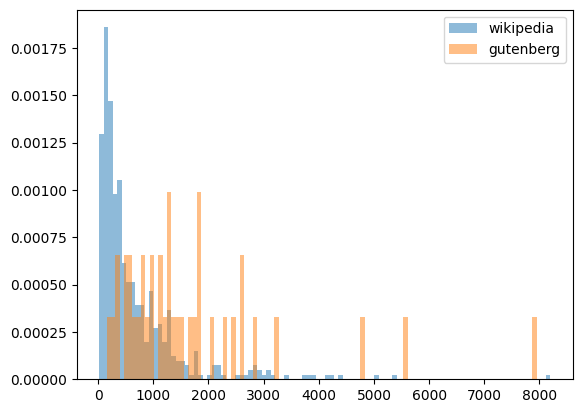

In [ ]:
plt.hist(wikilsums, bins=100, density=True, alpha=0.5, label="wikipedia")
plt.hist(gutlsums, bins=100, density=True, alpha=0.5, label="gutenberg")
plt.legend()
plt.show()

In [16]:
# code to get stuff ready for linear scan (wikipedia)
evset = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_ntrain_ptest/")
evset['test'] = evset['test'].select(range(0, len(evset['test']), 3))
evset.save_to_disk("../propercache/data/colbert_training/gemini_ntrain_ptest_3")

Saving the dataset (0/1 shards):   0%|          | 0/27000 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 998/998 [00:00<00:00, 36813.50 examples/s]


In [43]:
# load in some questions for wikipedia
wikitdata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_datav1")['test']
gutentdata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_gutenbergtrain")['train']
abstdata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_abstracttrain/")['train']

# wd = pickload("../propercache/data/datastores/wikipedia_docs_8chunksparagraph.pkl")
# wdflat = [i for j in wd for i in j]
wdflat = Dataset.load_from_disk("../propercache/data/datastores/wikipedia_8chunk_150k/")
gutendocdata = Dataset.load_from_disk("../propercache/data/datastores/gutenberg_chunks_800k/")
absdocdata = Dataset.load_from_disk("../propercache/data/datastores/fullabstractset/")

In [48]:
from setretrieval.datagen.data_utils import filter_docdata
# we want to get 10k clean random chunks from gutendocdata
filtdata = gutendocdata.filter(filter_docdata)

Filter: 100%|██████████| 299582/299582 [00:02<00:00, 143948.55 examples/s]


In [13]:
filt10k = filtdata.shuffle(seed=42).select(range(10000))
# save filt10k
filt10k.save_to_disk("../propercache/data/datastores/gutenberg_chunks_10k_decont")
# randomly print 50 chunks

Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:00<00:00, 68100.07 examples/s]


In [11]:
guttraindata = DatasetDict.load_from_disk("../propercache/data/colbert_training/gemini_gutenbergtrain")
guttraindata['test'] = guttraindata['test'].select(range(0, len(guttraindata['test']), 3))
# filter out bad docs
guttraindata['test'] = guttraindata['test'].filter(lambda x: filter_docdata(x, col='positive'))

Filter:   0%|          | 0/1001 [00:00<?, ? examples/s]

Filter: 100%|██████████| 1001/1001 [00:00<00:00, 58519.73 examples/s]


In [14]:
guttraindata.save_to_disk("../propercache/data/colbert_training/gemini_gutfilteredtrainqs")

Saving the dataset (0/1 shards):   0%|          | 0/27001 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 563/563 [00:00<00:00, 23433.26 examples/s]


In [11]:
# randomly print 50 chunks
randinds = random.sample(list(range(len(filtdata))), 50)
for i in randinds:
    print(filtdata[i]['text'])
    print("-"*100)
# get 10k random chunks from filtdata
randchunks = [filtdata[i] for i in random.sample(list(range(len(filtdata))), 10000)]


EXTENUATING CIRCUMSTANCES. This expression is used in law with reference to crimes, to describe cases in which, though an offence has been committed without legal justification or excuse, its gravity, from the point of view of punishment or moral opprobrium, is mitigated or reduced by reason of the facts leading up to or attending the commission of the offence. According to English procedure, the jury has no power to determine the punishment to be awarded for an offence. The sentence, with certain exceptions in capital cases, is within the sole discretion of the judge, subject to the statutory prescriptions as to the kind and maximum of punishment. It is common practice for juries to add to their verdict, guilty or not guilty, a rider recommending the accused to mercy on the ground of grave provocation received, or other circumstances which in their view should mitigate the penalty. This form of rider is often added on a verdict of guilty of wilful murder, a crime as to which the judge

In [6]:
basecpath = "../propercache/cache/gendata/"
# get all files which contain v8 or v9 in the filename, for each of these, get the size of the intersection
# of chunks_to_inds(pickload(file)[0]) with minichunks1
ncond = lambda x: x
ncond = lambda x: x>3000
ncond = lambda x: x>1000 and x<3000
ncond = lambda x: x<1000
for files in os.listdir(basecpath):
    if "v8" in files and "geminipro" in files:
        print(files)
        chunks1 = chunks_to_inds(pickload(os.path.join(basecpath, files))[0])
        chunks1 = set([c for c in chunks1 if ncond(c)])
        chunks2 = chunks_to_inds(pickload(os.path.join(basecpath, files.replace("v8", "v9")))[0])
        chunks2 = set([c for c in chunks2 if ncond(c)])
        print(len(set(chunks1) & set(chunks2)), len(set(chunks1)), len(set(chunks2)))
        try:
            print(len(set(chunks1) & set(chunks2)) / len(set(chunks1)))
        except:
            print(0)

ed4eeb4d1b1952c21cae30a6c94dafe571f1f3d3221cb89c7aba3e2e86f8639egeminiprov8_0.pkl
8 8 11
1.0
dffcbd838f874104fb3a36eb6ba79074c8f19c56c78bbefbe09a4923d86095dcgeminiprov8_0.pkl
1 1 1
1.0
8e837ac74cd2436910b7e29a11765a26a73db2816a0960290a03c5d47ff20577geminiprov8_0.pkl
6 6 7
1.0
1dd6f16b8c7f89401a3c9ead82e46762e3e503feed14ccf16688a7415f1c0d81geminiprov8_0.pkl
0 0 0
0
7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiprov8_0.pkl
1 1 2
1.0
58b81264d2665a81e65b10de95c645719a0be18840e4254921aba1607b7eb967geminiprov8_0.pkl
2 2 2
1.0


In [4]:
os.listdir(basecpath)

['ec4a0513cbcf1c051b3f962e1c55ca72cf4eb8ba69290cca6957e8dc0fd506e2_0.pkl',
 '7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiflashv1_0.pkl',
 'passagesearchtrain_v2260b3e78f88f6388ef18f57951467dd9fb6dac462a2c9c84e235b79e1c6173a3_6c1609c7a587dedad2965e4d0133b0ecf267e26d572909be0cf3f768775d47f1_0_125_0.pkl',
 'passagesearchtrain_v2f5880357f7dbb4e0b8ca2cf4e5c608501d669e172768317f42832cd067861aa2_84e3e8a3817cd651c957970116d8bdc38b9bf07ca46992a98aeb5a2c16223a97_0_2_0.pkl',
 '7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiprov2_0.pkl',
 'passagesearchtrain_v1_5.2k_4Bstart_0.pkl',
 '58b81264d2665a81e65b10de95c645719a0be18840e4254921aba1607b7eb967qwen38bv8_0.pkl',
 'passagesearchtrain_v21c51430d13dec532fdf390bf0d50e83cbdf2eff189249449295ed47af7112765_84e3e8a3817cd651c957970116d8bdc38b9bf07ca46992a98aeb5a2c16223a97_0_2_0.pkl',
 'passagesearchtrain_v22fe3ba78e6a201ef8764968d9474ace4a3ce343ea28f0883342daec086a0ba7c_7b6c41833a05c017a3775c130cc7840bdbf7b

In [14]:
ncond = lambda x: x
ncond = lambda x: x>3000
ncond = lambda x: x>1000 and x<3000
ncond = lambda x: x<1000




smallmod = "qwen38b"
smallmod = "geminiflashlite"

for files in os.listdir(basecpath):
    if "v8" in files and smallmod in files:
        print(files)
        chunks1 = chunks_to_inds(pickload(os.path.join(basecpath, files))[0])
        chunks1 = set([c for c in chunks1 if ncond(c)])
        try:
            chunks2 = chunks_to_inds(pickload(os.path.join(basecpath, files.replace(smallmod, "geminipro")))[0])
            chunks2 = set([c for c in chunks2 if ncond(c)])
            print(len(set(chunks1) & set(chunks2)), len(set(chunks1)), len(set(chunks2)))
        
            print(len(set(chunks1) & set(chunks2)) / len(set(chunks2)))
        except:
            print(0)

ce9931244023639557493dd332b8bf2caf3681aa7235158f6e294b7e81e1310bgeminiflashlitev8_0.pkl
0
7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiflashlitev8_0.pkl
0 9 1
0.0
8223993e6042df9206e6162e558be1f019ea47743e27654b017157c589285b07geminiflashlitev8_0.pkl
0
1dd6f16b8c7f89401a3c9ead82e46762e3e503feed14ccf16688a7415f1c0d81geminiflashlitev8_0.pkl
0 4 0
0
dffcbd838f874104fb3a36eb6ba79074c8f19c56c78bbefbe09a4923d86095dcgeminiflashlitev8_0.pkl
1 1 1
1.0
ed4eeb4d1b1952c21cae30a6c94dafe571f1f3d3221cb89c7aba3e2e86f8639egeminiflashlitev8_0.pkl
7 17 8
0.875
8e837ac74cd2436910b7e29a11765a26a73db2816a0960290a03c5d47ff20577geminiflashlitev8_0.pkl
4 12 6
0.6666666666666666
58b81264d2665a81e65b10de95c645719a0be18840e4254921aba1607b7eb967geminiflashlitev8_0.pkl
2 6 2
1.0


In [89]:
ncond = lambda x: x
ncond = lambda x: x>1000 and x<3000
ncond = lambda x: x>3000
ncond = lambda x: x<1000

for files in os.listdir(basecpath):
    if "v8" in files and "geminiflashlite" in files:
        print(files)
        chunks1 = chunks_to_inds(pickload(os.path.join(basecpath, files))[0])
        chunks1 = set([c for c in chunks1 if ncond(c)])
        chunks2 = chunks_to_inds(pickload(os.path.join(basecpath, files.replace("geminiflashlite", "geminipro")))[0])
        chunks2 = set([c for c in chunks2 if ncond(c)])
        print(len(set(chunks1) & set(chunks2)), len(set(chunks1)), len(set(chunks2)))
        try:
            print(len(set(chunks1) & set(chunks2)) / len(set(chunks2)))
        except:
            print(0)

In [43]:
# compare
rchunks1 = set(chunks_to_inds(pickload("../propercache/cache/gendata/7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiprov1_0.pkl")[0]))
rchunks2 = set(chunks_to_inds(pickload("../propercache/cache/gendata/7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiprov2_0.pkl")[0]))
rchunks3 = set(chunks_to_inds(pickload("../propercache/cache/gendata/7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiprov3_0.pkl")[0]))
rchunks4 = set(chunks_to_inds(pickload("../propercache/cache/gendata/7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiprov4_0.pkl")[0]))
rchunks5 = set(chunks_to_inds(pickload("../propercache/cache/gendata/7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiprov5_0.pkl")[0]))
rchunks6 = set(chunks_to_inds(pickload("../propercache/cache/gendata/7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiprov6_0.pkl")[0]))
rchunks7 = set(chunks_to_inds(pickload("../propercache/cache/gendata/7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiprov7_0.pkl")[0]))
rchunks8 = set(chunks_to_inds(pickload("../propercache/cache/gendata/7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiprov8_0.pkl")[0]))


minichunks1 = set(chunks_to_inds(pickload("../propercache/cache/gendata/7377664e8cc49dbb9049ea28ad9b23172f897b462e8f8f1f0df080184b33bf83geminiflashv1_0.pkl")[0]))
# get precision, recall
print(len(rchunks1 & rchunks2 & rchunks3 & rchunks4) / len(rchunks1))
print(len(rchunks1 & rchunks2 & rchunks3 & rchunks4) / len(rchunks2))
# check with minichunks 
agreeset = set(rchunks1 & rchunks2 & rchunks3 & rchunks4)
miniprec = len(agreeset & minichunks1) / len(agreeset)
fullset = set(rchunks1 | rchunks2 | rchunks3 | rchunks4)
miniprec2 = len(fullset & minichunks1) / len(fullset)
print(miniprec, len(agreeset), len(fullset))
print(miniprec2, len(fullset & minichunks1), len(fullset))

0.24444444444444444
0.19642857142857142
0.6666666666666666 33 316
0.5569620253164557 176 316


In [47]:
# agreement between 5 and 6
print(len(rchunks7 & rchunks8) / len(rchunks8))
# print(len(rchunks5 & rchunks6) / len(rchunks6))


0.6296296296296297


In [ ]:
print(len(rchunks1 & rchunks2) / len(rchunks1))

0.4962962962962963


In [33]:
gutentdata[0]

{'query': 'What are passages that describe a process where human skill compensates for a lack of mechanical assistance?',
 'positive': 'In the field all guns have to be loaded by hand. The elaborate system of hoists which enables the great naval guns to be loaded with such rapidity is obviously impossible. That has to be compensated for by the skill and quickness of the gunners themselves, and it is indeed astonishing to see with what deftness they can handle the heavy and dangerous projectiles.With all guns, of whatever kind, range-finding is of the utmost importance. No projectile, however fast it may travel, really moves in a straight line. It must be fired more or less upwards in order to compensate for the downward pull of gravity. If the elevation be insufficient the shell will fall short; if it be too much it may go beyond the mark, or it may fall short, according to circumstances. Just the right elevation is absolutely essential for good shooting. And for that to be achieved th

In [ ]:
gutenuseqs = [
    'What are passages that explain the fundamental principles behind a technical activity?',
    'What are passages that illustrate a concept by first stating a general rule and then providing the consequences of deviating from it?',
    'Which passages offer guidance on personal conduct and achieving success?',
    "Which passages describe a character's exploration leading to the discovery of a vital resource?",
    "Which passages describe a situation involving a case of mistaken identity?"
]
wikiuseqs = [
    'Which passage describes a project being revived after a period of political suppression?',
    'Which passage describes a project as being a middle installment of a larger series?',
    'What passage describes a series of investigations into a single subject over a long period of time?',
    'What passage describes a subject for which a key piece of information remains unknown due to technical limitations?',
    "Which passage describes how a group's successful smaller operations contributed to an increase in its membership?"
]

# inds of gutentdata where query is each of the gutenuseqs
guteninddata = [gutentdata[i] for i in get_dsinds(gutentdata, gutenuseqs)]
wikinddata = [wikitdata[i] for i in get_dsinds(wikitdata, wikiuseqs)]
gutendocs = set([r['positive'] for r in guteninddata])
wikidocs = set([r['positive'] for r in wikinddata])
# get original doc id in full data of relevant document for each ind
gdocinds = [gutendocdata[i] for i in get_dsinds(gutendocdata, gutendocs, query_col='text')]
wdocinds = [wdflat[i] for i in get_dsinds(wdflat, wikidocs, query_col='text')]
# convert into chunk sets
gd2q = {row['positive']: row['query'] for row in guteninddata}
wd2q = {row['positive']: row['query'] for row in wikinddata}

100%|██████████| 152237/152237 [00:02<00:00, 52690.58it/s]


In [ ]:
# cell to process wikipedia docs a bit (for next datastore part)
# wdflat = [w for w in wdflat if len(w['text']) > 10]
# wdfdset = Dataset.from_list(wdflat)
# wdfdset.save_to_disk("../propercache/data/datastores/wikipedia_8chunk_150k")

In [ ]:
# recipe for different kinds of chunk windows: 3 different kinds below

In [44]:
# 1. find all chunks with same id as positive, sample 5 randomly
wikisameidlists, gutensameidlists = {}, {}
# key is positive chunk text
for w in wdocinds:
    wikisameidlists[wd2q[w['text']]] = [wdflat[i] for i in get_dsinds(wdflat, set([w['id']]), query_col='id')]
for g in gdocinds: 
    gutensameidlists[gd2q[g['text']]] = [gutendocdata[i] for i in get_dsinds(gutendocdata, set([g['id']]), query_col='id')]

  0%|          | 0/152237 [00:00<?, ?it/s]

100%|██████████| 299582/299582 [00:05<00:00, 56121.67it/s]


In [45]:
qweneasyindex = SingleEasyIndexer(model_name="Qwen/Qwen3-Embedding-4B", index_base_path="../propercache/cache/single_indices/", num_gpus=0)

In [55]:
from setretrieval.datagen.data_utils import qtosearchlists, checktoverlap


In [ ]:
# 2. embedding model top 1K over larger window
# External HACK: make sure to get indices w/ Qwen/Qwen3-Embedding-4B, run the following: 
# for wikipedia ->  python scripts/precompute_index.py --index_type "single" --model_name "Qwen/Qwen3-Embedding-4B" --dataset_path "propercache/data/datastores/wikipedia_8chunk_150k"
# for gutenberg ->  python scripts/precompute_index.py --index_type "single" --model_name "Qwen/Qwen3-Embedding-4B" --dataset_path "propercache/data/datastores/gutenberg_chunks_800k"

wikinearsearchlists = qtosearchlists(qweneasyindex, wikiuseqs, wdflat, 'wikipedia')
gutlinearsearchlists = qtosearchlists(qweneasyindex, gutenuseqs, gutendocdata, 'gutenberg')
# these overlap numbers a bit high... should double check to see if embedding models are an ok initial filter for set retrieval
checktoverlap(wikisameidlists, wikinearsearchlists)
checktoverlap(gutensameidlists, gutlinearsearchlists)

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches: 100%|██████████| 5/5 [00:03<00:00,  1.53it/s]


In [62]:
# 3. random sample 1K documents
wikirands = [wdflat[i] for i in random.sample(list(range(len(wdflat))), 1000)]
gutterands = [gutendocdata[i] for i in random.sample(list(range(len(gutendocdata))), 1000)]

In [ ]:
# for large scale check experiment C

wikirands100 = [wdflat[i] for i in random.sample(list(range(len(wdflat))), 100000)]
gdfilt = filtdata.shuffle(seed=42).select(range(100000))
# Dataset.from_list(wikirands100).save_to_disk("../propercache/data/datastores/sanitychecks/wikirands100k")
# gdfilt.save_to_disk("../propercache/data/datastores/sanitychecks/gutterands100k")

Saving the dataset (0/1 shards):  32%|███▏      | 32000/100000 [00:00<00:00, 69543.19 examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 100000/100000 [00:01<00:00, 71144.93 examples/s]


In [56]:
gut2qs = list(gutenmanypos['query'])
wik2qs = list(wikimanypos['query'])
# get indices of gut2qs and wik2qs in gutentdata and wikitdata
gutinds = qtosearchlists(qweneasyindex, gut2qs, gutendocdata, 'gutenberg', 5000)
wikinds = qtosearchlists(qweneasyindex, wik2qs, wdflat, 'wikipedia', 5000)

[2025-12-27 11:42:41] INFO SentenceTransformer.py:227: Load pretrained SentenceTransformer: Qwen/Qwen3-Embedding-4B


Loaded index propercache_data_datastores_gutenberg_chunks_800k from cache with 299582 documents
Loading vanilla sentence transformer model


Loading checkpoint shards: 100%|██████████| 2/2 [00:11<00:00,  5.86s/it]
[2025-12-27 11:42:56] INFO SentenceTransformer.py:378: 1 prompt is loaded, with the key: query
Batches: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]


Loaded index propercache_data_datastores_wikipedia_8chunk_150k from cache with 152237 documents


Batches: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]


In [ ]:
gutrankflat = list(gutinds.values())
wikrankflat = list(wikinds.values())
gutrankflat = gutrankflat[0] + gutrankflat[1]
wikrankflat = wikrankflat[0] + wikrankflat[1]
# Dataset.from_list(gutrankflat).save_to_disk("../propercache/data/datastores/sanitychecks/guttinytop5k")
# Dataset.from_list(wikrankflat).save_to_disk("../propercache/data/datastores/sanitychecks/wikitinytop5k")

Saving the dataset (1/1 shards): 100%|██████████| 10000/10000 [00:00<00:00, 96136.79 examples/s]


In [66]:
# save all of these to propercache/data/datastores/sanitychecks
# pickdump(wikirands, "../propercache/data/datastores/sanitychecks/wikirands.pkl")
# pickdump(gutterands, "../propercache/data/datastores/sanitychecks/gutterands.pkl")
def add_dtypelist(initlist, newlist, dtype):
    for doc in newlist:
        doc['doctype'] = dtype
    initlist.extend(newlist)

for k in wikisameidlists: 
    # put it all into one list, add doctype key (rand, search, sameid) to dicts from each relevant source
    all_docs = []
    add_dtypelist(all_docs, wikirands, 'rand')
    add_dtypelist(all_docs, wikinearsearchlists[k], 'search')
    add_dtypelist(all_docs, wikisameidlists[k], 'sameid')
    print(len(all_docs))
    Dataset.from_list(all_docs).save_to_disk(f"../propercache/data/datastores/sanitychecks/wikisameidlists_{get_deterministic_hash(k)}")
for k in gutensameidlists: 
    all_docs = []
    add_dtypelist(all_docs, gutterands, 'rand')
    add_dtypelist(all_docs, gutlinearsearchlists[k], 'search')
    add_dtypelist(all_docs, gutensameidlists[k], 'sameid')
    print(len(all_docs))
    Dataset.from_list(all_docs).save_to_disk(f"../propercache/data/datastores/sanitychecks/gutensameidlists_{get_deterministic_hash(k)}")


3015


Saving the dataset (1/1 shards): 100%|██████████| 3015/3015 [00:00<00:00, 8765.90 examples/s]


3015


Saving the dataset (1/1 shards): 100%|██████████| 3015/3015 [00:00<00:00, 9281.42 examples/s]


3013


Saving the dataset (1/1 shards): 100%|██████████| 3013/3013 [00:00<00:00, 8963.40 examples/s]


3012


Saving the dataset (1/1 shards): 100%|██████████| 3012/3012 [00:00<00:00, 8649.28 examples/s]


3360


Saving the dataset (1/1 shards): 100%|██████████| 3360/3360 [00:00<00:00, 6933.48 examples/s]


3114


Saving the dataset (1/1 shards): 100%|██████████| 3114/3114 [00:00<00:00, 6813.07 examples/s]


3282


Saving the dataset (1/1 shards): 100%|██████████| 3282/3282 [00:00<00:00, 6767.32 examples/s]


3535


Saving the dataset (1/1 shards): 100%|██████████| 3535/3535 [00:00<00:00, 6729.94 examples/s]


In [59]:
len(set([r['text'] for r in gutendocdata]))

228188

In [42]:
wikinearsearchlists['Which passage describes a project being revived after a period of political suppression?']

[{'text': "Freedom of the press also opened the door for the first honest look at Czechoslovakia's past by Czechoslovakia's people. Many of the investigations centered on the country's history under communism, especially in the instance of the Joseph Stalin-period. In another television appearance, Goldstucker presented both doctored and undoctored photographs of former communist leaders who had been purged, imprisoned, or executed and thus erased from communist history. The Writer's Union also formed a committee in April 1968, headed by the poet Jaroslav Seifert, to investigate the persecution of writers after the Communist takeover in February 1948 and rehabilitate the literary figures into the Union, bookstores and libraries, and the literary world. Discussions on the current state of communism and abstract ideas such as freedom and identity were also becoming more common; soon, non-party publications began appearing, such as the trade union daily Práce (Labour). This was also helpe

In [15]:
wikiuseqs[0]

'Which passage describes a project being revived after a period of political suppression?'

In [28]:
searchres = qweneasyindex.search(["What are social ecological models?"], wid, k=1000)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


In [30]:
wdflat[searchres[0][0]['index']]

{'text': "Kelly's ecological model focused on four key constructs from biological ecology that he applied to human systems and designing community-based intervention: 1) Interdependence; 2) Adaptation; 3) Resource Cycling: and 4) Succession. Interdependence is the idea that a program is connected to other aspects of the context in which it operates including behaviors other than the ones that are the focus of the intervention, other programs that may exist in the organization or community in which the intervention is located, and the cultural context in which the program operates. Adaptation applies to the idea that all interventions need to be able to adapt to changing environmental circumstances so they need to be organized in a flexible and modifiable fashion from the start. Resource Cycling focuses attention on the resources that must be obtained and managed over time including space, staff skills, financial, and other assets critical for organizational success. Succession is the i

In [12]:
searchres[0]

[{'score': np.float32(1.0127745),
  'index': np.int64(131173),
  'index_id': 'propercache_data_datastores_wikipedia_8chunk_150k'},
 {'score': np.float32(1.0387353),
  'index': np.int64(72537),
  'index_id': 'propercache_data_datastores_wikipedia_8chunk_150k'},
 {'score': np.float32(1.0608428),
  'index': np.int64(104007),
  'index_id': 'propercache_data_datastores_wikipedia_8chunk_150k'},
 {'score': np.float32(1.0690397),
  'index': np.int64(106228),
  'index_id': 'propercache_data_datastores_wikipedia_8chunk_150k'},
 {'score': np.float32(1.0711384),
  'index': np.int64(19252),
  'index_id': 'propercache_data_datastores_wikipedia_8chunk_150k'},
 {'score': np.float32(1.071575),
  'index': np.int64(19893),
  'index_id': 'propercache_data_datastores_wikipedia_8chunk_150k'},
 {'score': np.float32(1.0723166),
  'index': np.int64(19253),
  'index_id': 'propercache_data_datastores_wikipedia_8chunk_150k'},
 {'score': np.float32(1.0755628),
  'index': np.int64(110388),
  'index_id': 'propercach

In [19]:
qweneasyindex.index_exists(wid)

True

In [124]:
# 3. random sample 1K documents
randwikichunks = [wdflat[i] for i in random.sample(list(range(len(wdflat))), 1000)]
randgutenchunks = [gutendocdata[i] for i in random.sample(list(range(len(gutendocdata))), 1000)]

In [ ]:
# for each query, get top 1K 

In [97]:
wdocinds

[66390, 66401, 66403, 66417]

In [ ]:
# for questions in 

In [20]:
wikitdata[15]

{'query': "Which passage describes how a group's successful smaller operations contributed to an increase in its membership?",
 'positive': "At the beginning of 1948,DSE controlled all of Peloponnese's main mountain ranges including Taygetus, Parnon and Mainalo. While DSE held most of the mountainous Kalavryta province, its capital of the same name remained in government hands. Kalavryta held a strategic position in the triangle of Patras, Tripoli and the peninsula's northern coast. DSE saw Kalavryta as an important target due to its relative isolation from other state garrisons, the abundance of food, clothing and military equipment held in its warehouses as well as the potential of openly recruiting the residents of numerous left leaning villages surrounding it. DSE was also hoping to gain a foothold on the Gulf of Corinth in order to open a new supply route from Central Greece. Following two successful ambushes at Vaggos and Tropaia on 3 and 9 March respectively, DSE destroyed four 

['Which passage describes a project being revived after a period of political suppression?',
 'Which passage describes a project as being a middle installment of a larger series?',
 'What passage describes a series of investigations into a single subject over a long period of time?',
 'What passage describes a subject for which a key piece of information remains unknown due to technical limitations?',
 "Which passage describes how a group's successful smaller operations contributed to an increase in its membership?"]